In [1]:
import os
import utils
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
import statsmodels.formula.api as smf
from glob import glob
from datetime import datetime
import tensorflow as tf
import keras
from keras import Input, layers
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D, LeakyReLU, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.utils import np_utils
import random
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from fireTS.models import NARX
seed_value = 2022
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
from sklearn.preprocessing import QuantileTransformer 
normalizer = QuantileTransformer(output_distribution='normal')

In [2]:
lob_data=utils.caricaLOB('msft',1)
ld=lob_data.values.tolist()
of=utils.OF_1(ld)
bCols=np.ravel([['aOF_%d'%level, 'bOF_%d'%level] for level in [1,2,3]])
of_data=pd.DataFrame(of, columns=bCols)
m=pd.DataFrame(utils.midPrice(lob_data),columns=['m'])
m['r']=m['m'].diff().fillna(0).copy()
ret=utils.preparaRitorni(m,'msft')
of = pd.concat([of_data[-len(ret):], ret], axis=1)

In [3]:
dt=utils.deltaT(m['r'])
hk=utils.doHk(dt,11)
hk

array([ 0.,  4.,  8., 13., 17., 22., 26., 31., 35., 40., 44.])

In [4]:
V = int(len(of)*0.6)
T = int(len(of)*0.8)

n_train     = of.iloc[ :V].copy()
n_vali      = of.iloc[V:T].copy()
n_test      = of.iloc[T: ].copy()

n_train = n_train.apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_vali  = n_vali .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)
n_test  = n_test .apply(lambda x : utils.taglia_e_cuci(x), axis=1, raw=True)

x_vars = of.columns#[:-10]

# Normalize Features
# Dividing by the standard deviation estimated using the training set
for x_var in x_vars:
    sd = n_train[x_var].std()
    n_train[x_var] = n_train[x_var] / sd
    n_vali [x_var] = n_vali [x_var] / sd
    n_test [x_var] = n_test [x_var] / sd

trainX,trainY = utils.prepXY  (n_train, typo = 'cnnlstm')    
valiX ,valiY  = utils.prepXY  (n_vali , typo = 'cnnlstm')    
testX ,testY  = utils.prepXY  (n_test , typo = 'cnnlstm')   


print(trainX.shape ,trainY.shape)
print(valiX.shape  ,valiY .shape)
print(testX.shape  ,testY .shape)

(629018, 100, 6, 1) (629018, 10)
(209606, 100, 6, 1) (209606, 10)
(209607, 100, 6, 1) (209607, 10)


In [5]:
#architettura della rete
def create_nn(T, NF,number_of_lstm):

    input_lmd = tf.keras.Input(shape=(T, NF, 1))

    conv_first1 = Conv2D(32, kernel_size=(1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    #
    layer_x = layers.Conv2D(filters=16, kernel_size=(10,1),strides=(1,10), padding='same')(conv_first1)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    # inception
    convsecond_1 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same', strides=(1,1))(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(layer_x)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same', strides=(1,1))(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(layer_x)
    convsecond_3 = Conv2D(64, (1, 1), padding='same', strides=(1,1))(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)
    
    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.3, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    #  LSTM layer
    conv_lstm = LSTM(number_of_lstm)(conv_reshape)
    # output layer
    out = Dense(10, activation='leaky_relu')(conv_lstm) #prova a mettere TY=number of steps in the output
    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=adam, loss='mse')#, metrics=['accuracy']

    return model
  
deeplob = create_nn(100, 6, 64)
checkpoint_filepath = './model_tensorflow2/weights'

callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)
saving = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#deeplob.summary()

In [6]:
simple=deeplob.load_weights('modelMSFTpit.h5')
#simple=deeplob.fit(trainX, trainY, validation_data=(valiX, valiY),  epochs=50, batch_size=256,callbacks=[callback,saving])


In [7]:
#deeplob.save('modelMSFT.h5')

In [8]:
#loss=simple.history['loss']
#lossVal=simple.history['val_loss']
#lossVal

In [9]:
#plt.plot(simple.history['loss']    [1:], label='train loss')
#plt.plot(simple.history['val_loss'][1:], label='test loss')
#plt.legend()
#plt.show()

In [10]:
Ptrain= deeplob.predict(trainX)
Ptest = deeplob.predict(testX)

6551/6551 [==============================] - 194s 30ms/step


In [11]:
r2os = np.zeros(10)
for i in range(10):
    r2os[i]=1-mse(y_pred=Ptest[:,i],y_true=testY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(testY),y_true=testY[:,i])
r2os

array([6.10491604e-05, 1.71485467e-04, 2.76154018e-04, 3.54907278e-04,
       4.07026441e-04, 4.25478700e-04, 4.02356142e-04, 4.31062517e-04,
       4.21607692e-04, 2.88154812e-04])

In [12]:
r2is = np.zeros(10)
for i in range(10):
    r2is[i]=1-mse(y_pred=Ptrain[:,i],y_true=trainY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(trainY),y_true=trainY[:,i])
r2is

array([9.01529117e-05, 1.96428636e-04, 2.94785865e-04, 3.65498985e-04,
       4.12688971e-04, 4.42126023e-04, 4.25913884e-04, 4.59386012e-04,
       4.66245881e-04, 4.33956890e-04])

In [ ]:
plt.plot(testY)
plt.plot(Ptest,label='pred')
plt.legend();

In [ ]:
plt.plot(trainY)
plt.plot(Ptrain,label='pred')
plt.legend();

In [15]:
r2_score(y_pred=Ptest,y_true=testY), r2_score(y_pred=Ptrain,y_true=trainY)

(0.00030477074975684417, 0.00035871840537643473)

In [ ]:
x = n_train.iloc[:,:6]
y = n_train.iloc[:,6:]

yfor =np.empty((len(valiY),10))

for i in range(10):
    mdl = NARX(LinearRegression(), auto_order=1, exog_order=[100,100,100,100,100,100])
    mdl.fit(x,y.iloc[:,i])
    yfor[:,i] = mdl.forecast(x,y.iloc[:,i],step=len(valiY))

In [ ]:
r2ARXos = np.zeros(10)
for i in range(10):
    r2ARXos[i]=1-mse(y_pred=yfor[:,i],y_true=valiY[:,i])/mse(y_pred=[np.mean(trainY[:,i])]*len(valiY),y_true=valiY[:,i])
r2ARXos

array([-0.004099  , -0.00698214, -0.01116444, -0.01464862, -0.01664253,
       -0.02092974, -0.0242792 , -0.02731152, -0.03288531, -0.04752954])

In [ ]:
r2_score(y,n_train.iloc[:,-10:]),  r2_score(yfor,valiY)

(1.0, -2659.564203433751)

In [ ]:
r2ARXis = np.zeros(10)
for i in range(10):
    r2ARXis[i]=1-mse(y_pred=y.iloc[:,i],y_true=n_train.iloc[:,-10+i])/mse(y_pred=[np.mean(n_train.iloc[:,-10+i])]*len(n_train.iloc[:,-10+i]),y_true=n_train.iloc[:,-10+i])
r2ARXis

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

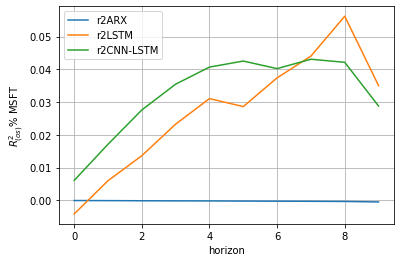

In [2]:
r2LSTMos=np.array([-4.12890170e-05,  6.01415292e-05,  1.36529848e-04,  2.32861733e-04,  3.10779234e-04,  2.86474758e-04,  3.74157949e-04,  4.40611975e-04,   5.62302265e-04,  3.50433006e-04])#-5.16180802, -0.43551043, -1.14233702, -1.52269309, -0.22551861,       -0.45537046, -1.08934072, -0.45201413, -0.02923267, -0.92230677])
r2ARXos=np.array([-0.004099  , -0.00698214, -0.01116444, -0.01464862, -0.01664253,       -0.02092974, -0.0242792 , -0.02731152, -0.03288531, -0.04752954])
r2os=np.array([6.10491604e-05, 1.71485467e-04, 2.76154018e-04, 3.54907278e-04,       4.07026441e-04, 4.25478700e-04, 4.02356142e-04, 4.31062517e-04,        4.21607692e-04, 2.88154812e-04])
plt.plot(r2ARXos /100,label='r2ARX'     )
plt.plot(r2LSTMos*100,label='r2LSTM'    )
plt.plot(r2os    *100,label='r2CNN-LSTM')
plt.grid(True)
plt.ylabel('$R^2_{(os)}\%$ MSFT')
plt.xlabel('horizon')
plt.legend();

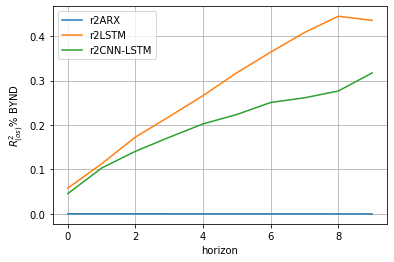

In [3]:
r2LSTMosB=np.array([0.00057878, 0.00112619, 0.00172947, 0.0021896 , 0.00266304,        0.00317812, 0.00364115, 0.00408428, 0.00444944, 0.00435618])#[-0.41097385,  0.04266487, -0.2145984 ,  0.17390238,  0.05973878,       -0.21622171, -0.16653226, -0.19861038, -0.23133067, -0.76287042]#np.array([-2.03300819,  0.12142431, -0.40861081,  0.0687946 ,  0.0229519 , 0.05173136, -0.06193211, -0.01980576, -0.20360118, -0.52021882])#[-0.45311069,  0.04605449, -0.1948343 ,  0.17900163,  0.06497519,  -0.22647752, -0.14808458, -0.19544776, -0.23445491, -0.72659964])
r2os1B=np.array([0.00045558, 0.00103086, 0.00140875, 0.00172428, 0.00202595,       0.00223761, 0.00250747, 0.00261251, 0.00276625, 0.00317418])#.array([0.15785287, 0.31554607, 0.46024276, 0.46678679, 0.44605147,       0.42156301, 0.39472172, 0.36715091, 0.34375688, 0.32292426])
r2ARXosB=np.array([-0.00230016, -0.00403902, -0.00543192, -0.00765263, -0.00932394,        -0.01107322, -0.01388463, -0.01531228, -0.02136328, -0.02032713])#np.array([ 3.63381619e-05,  3.89777082e-05,  2.37661840e-04,  1.12481813e-04,        1.74148868e-04,  2.06452389e-04,  1.52446244e-04,  2.29640493e-04,        1.64217530e-04, -2.85535958e-05])
plt.plot(r2ARXosB /100,label='r2ARX')
plt.plot(r2LSTMosB*100,label='r2LSTM')
plt.plot(r2os1B   *100,label='r2CNN-LSTM')
plt.grid(True)
plt.ylabel('$R^2_{(os)}\%$ BYND')
plt.xlabel('horizon')
plt.legend();